Lets begin by importing the various packages we will be using for this notebook

In [14]:
import os
os.chdir('../')


import ossPyFuncs
import pandas as pd
import wordcloud
import re
import matplotlib.pyplot as plt

import numpy as np

Although we can't directly view the raw data in this notebook, we can still get a sense of what it looks like in a broad sense.  Lets import the raw dataframe using an sql query and then look at some of the features of this data object.  We'll use a function from our custom python library (https://github.com/DSPG-Young-Scholars-Program/dspg20oss/tree/master/ossPy) to make this query

In [23]:
#perform sql query to get company column
postgreSql_selectQuery="SELECT company FROM gh.ctrs_raw ;"
inputRaw=ossPyFuncs.queryToPDTable(postgreSql_selectQuery)

dataFrameShape=inputRaw.shape
print(dataFrameShape)

(2143407, 1)


NameError: name 'pwd' is not defined

Here we see that the output of that query is a table with 2143407 rows and 1 column.  Those rows correspond to users, while the column corresponds to the disclosed professional affiliation.  Despite there being that many users though, not all of them actually listed this information.  Lets get a sense of how many that is.

In [3]:
numberOfNull=np.count_nonzero(pd.isnull(inputRaw['company']))

print(numberOfNull)

1720890


So how many users does that mean have entered data?

In [4]:
print(dataFrameShape[0]-numberOfNull)

422517


So, of these initial 2.1 million or so entries, only about 400 thousand have entries.  What do some of these company listings look like?  For example, what are the most frequently listed companies in this raw data?

In [5]:
#get the counts for the unique values
tableUniqueFullNameCounts=inputRaw.iloc[:,0].value_counts()
#convert that output to a proper table
tableUniqueFullNameCounts=tableUniqueFullNameCounts.reset_index()

#rename the columns
tableUniqueFullNameCounts.rename(columns={"company":"count","index":"company"},inplace=True)


#get rid of empty value
tableUniqueFullNameCounts=tableUniqueFullNameCounts[~tableUniqueFullNameCounts['company'].str.contains("^$")]
tableUniqueFullNameCounts=tableUniqueFullNameCounts.reset_index(drop=True)
#display table
tableUniqueFullNameCounts.head(n=15)

,company,count
0,Microsoft,4301
1,Google,2216
2,Red Hat,1594
3,IBM,1492
4,Freelancer,817
5,Freelance,795
6,@Microsoft,730
7,@Microsoft,674
8,Facebook,670
9,Intel,608


Here we see a number of names that we might expect to see.  For example, tech companies like Microsoft, Google, and IBM as well as status listings like Freelancer and Stduent.

However, from a "data cleanliness" perspective, we also notice that several of these listings are redundant.  For example, there appear to be at least two Google listings in just these most common fifteen listings, and three Microsoft listings!  This is just on the most common end of the listings, what about the least common end of things?

In [6]:
#display table
tableUniqueFullNameCounts.tail(n=20)

,company,count
262035,"Founder, Octolopagon Games",1
262036,CERT,1
262037,LifeGadget,1
262038,OvGU Magdeburg,1
262039,Die Kollaborateure,1
262040,MyFreeComm,1
262041,@gomemeperialgo,1
262042,Unthernet,1
262043,Asia Green Development Bank,1
262044,Matstage Inc.,1


Here we see a number of issues that we'll be needing to account for.  For example, listing 262036 features an apparent spelling error, in that there is no space between the A and & symbol.  Listing 262046 features two separate listings (using the @ symbol, no less), which we'll need to account for in our tabulations as well.  Finally, listings 262038, 262039, 262047, 262050, and 262052 all feature corporate entity abreviations.

All of these issues would stand as a challenge as we try and assess how many individuals work at the same organizations and within the same sectors (in virtue of the organizations' situationing within the sector breakdown).  This is in additon to the issues with listings we saw in the top most requent listings we saw earlier as well.  As such, there are a number of things we'll have to take care of as we preprocess this data.

What does the data look *as is* though, before any changes have been made?

<Figure size 3200x6400 with 0 Axes>

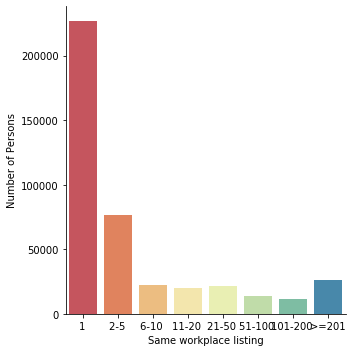

<Figure size 3200x6400 with 0 Axes>

In [13]:
companyCounts=tableUniqueFullNameCounts['count']

#establish the binvals
binVals=np.asarray([0,1,5,10,20,50,100,200,np.max(companyCounts)])

#iterate to sum the number of employees meeting the criterion
binSum=np.zeros([len(binVals)-1,1])
for iBins in range(len(binVals)-1):
    binSum[iBins]=sum(companyCounts[np.logical_and(companyCounts>binVals[iBins],companyCounts<=binVals[iBins+1])])

#import plotting package
import seaborn as sns
#set the name vector    
binNames=['1 ','2-5 ','6-10 ','11-20 ','21-50 ','51-100 ','101-200 ', '>=201']
#set the axes labels
workplaceSizeTable=pd.DataFrame(columns=["Same workplace listing","Number of Persons"])
workplaceSizeTable['Number of Persons']=np.squeeze(binSum)
workplaceSizeTable['Same workplace listing']=np.squeeze(binNames)

#plot the output
sns.catplot(data=workplaceSizeTable, kind="bar", x='Same workplace listing',y='Number of Persons', palette='Spectral');
plt.figure(figsize=(16,32),dpi=200)

Here we have a plot where there are various bin ranges corresponding to the number of other people who have *exactly* the same worplace affiliation listed on the X axis, and the number of people meeting that criteria on the Y axis.  Thus, to be included in the count of persons in the >=201 column/bin, the listing that the user has entered would need to be found listed by at least 201 other people.  This gives us a very rough sense of the overlap in these raw, and unchanged listings.  

Another way to get a sense of this is to use a word cloud to get a feel for the relative frequencies of unique company listings in this data.  This will allow us to see the the top 2000 listings in the raw data.

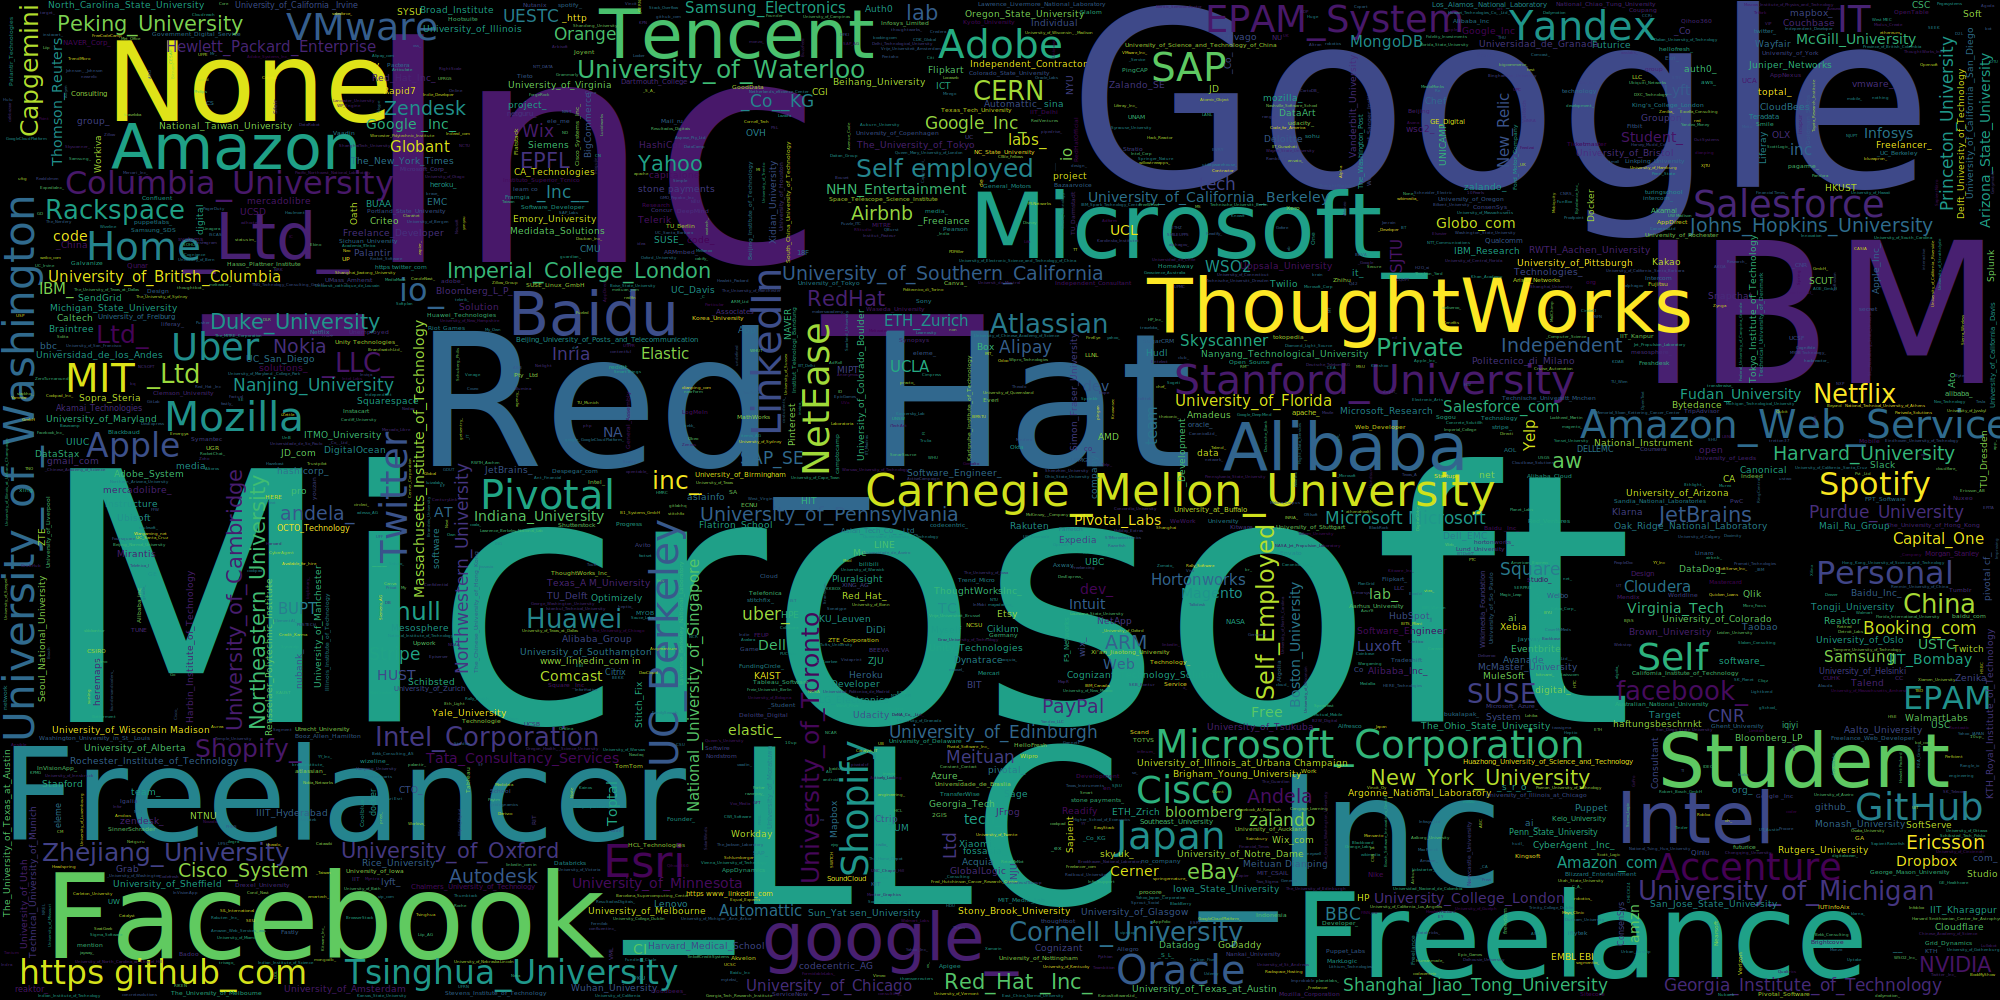

In [8]:
import wordcloud
import IPython
#replace interior spaces and periods (which the wordcloud splits at)
spacesReplaced=inputRaw['company'].str.replace(' ','_')
periodsReplaced=spacesReplaced.str.replace('\.','_')

#turn that output into a long string
longString=periodsReplaced.str.cat(sep=' ')

#generate a wordcloud and convert it to svg
outcloud=wordcloud.WordCloud(width=2000, height=1000, max_words=2000).generate(longString)
svgCloud=outcloud.to_svg()
IPython.display.SVG(svgCloud)

Finally, before doing *any* cleaning or remapping, we should take a snapshot of what our current raw data looks like.  By this I mean which users are currently associated with which company in the frequency table above.  Right now, this is just a direct mapping from the user indexes to the unique names (because nothing has changed).  By doing this now though, we'll be able to see which users have moved about due to our cleaning.  Also note that, one way to do this would be to loop over the unique company listing entries and see which user indexes would match up with them.  This would take an *Extremely* long time.  To get around this we'll use a custom function which cleverly makes use of some sorting algorithms behind the scenes.

In [15]:
#note that we have to drop the na values virst
inputColumn=inputRaw.dropna(inplace=False)

sortedInputColumn, sortedTableUniqueFullNameCounts=ossPyFuncs.uniquePandasIndexMapping(inputColumn)

uniqueCompaniesAndIndexes=sortedTableUniqueFullNameCounts.sort_values(by=['count'], ascending=False, inplace=False)
uniqueCompaniesAndIndexes.head(30)

/sfs/qumulo/qhome/dnb3k/git/dspg20oss/ossPy/ossPyFuncs.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputColumn.sort_values(by=['company'], inplace=True)
/apps/software/standard/core/anaconda/2019.10-py3.7/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,index,company,count,inputIndexMapping
262055,235792,~~~ vacation ~~~,1,[422516]
167672,240021,Olympic Park,1,[275264]
167673,135286,Olympic Software,1,[275265]
167674,193433,Olympic Software | LuGa,1,[275266]
167675,199958,Olympus Labs,1,[275267]
167676,51093,OlympusOne,1,[275268]
167678,38126,Om Services,1,[275271]
167679,113056,Om Vea,1,[275272]
167680,182055,Om7Sense GmbH,1,[275273]
167681,255332,OmCore,1,[275274]


Having completed this mappping our task now is twofold:

(1) Clean the data such that abberant features (e.g. capitalization, white space, legal entity listing, etc.) don't serve as an impediment to assessing how many people are affiliated with a particular organization

and

(2) To come up with a better measure that can accomidate the "messiness" associated with multiple listings in this field.

One good initial way to begin assessing our cleaning needs is by looking at the unique word "tokens" being used in the company affiliation field.  This is sort of like earlier, when we looked at the frequency of complete listings, except this time, we'll be considering each word individually rather than the workplace affilition field in its entirety.

In [16]:
#cat together all user's workplace names (note, we are not applying unique first)
longString=inputRaw['company'].str.cat(sep=' ')

#separate each word into a extremely long list
longStringSeparated=longString.split(' ')

#turn it into a dataframe
uniqueSubTokenFrame=pd.DataFrame(longStringSeparated)

#get the count on that column
columnUniqueCounts=uniqueSubTokenFrame.iloc[:,0].value_counts()
#convert that output to a proper table
tableUniqueCounts=columnUniqueCounts.reset_index()
tableUniqueCounts.rename(columns={0:"count","index":"token"},inplace=True)

print(tableUniqueCounts.shape)

tableUniqueCounts.head(15)

(223797, 2)


,token,count
0,,67043
1,University,23979
2,of,16580
3,Inc.,9882
4,Microsoft,4997
5,LLC,4947
6,Software,4944
7,GmbH,4401
8,Technology,4221
9,Ltd,3632


Here, we get a clear indication of just how frequent these legal entity abreviations are.  We see that listings 3, 5, 7, 9, 13 all correspond to this issue.  If we assume that some people do include this abrevation and that some people don't we see how this could be causing a great deal of "noise" in our data set.

One approach to this would be to go through and manually identify those tokens which correspond to legal entity abreviations.  This would be both time consuming (given that there are 2.2 million unique tokens to search through) and be predicated upon the assumption that we were capable of identifing legal entity abreviations across *all* countries and legal systems (given GitHub's global reach).

Instead, a good first approach might be to find an existing list of legal entity abreviations (e.g. https://www.gleif.org/en/about-lei/code-lists/iso-20275-entity-legal-forms-code-list) and to assess which of them might be worth including in a "removal list" (that is, a list of strings to be deleted from all workplace affiliation listings).

(WARNING: the following operation takes a good deal of time to perform.

In [ ]:
#perform sql query to get abreviation from gleif database
postgreSql_selectQuery="SELECT local_language_abbreviation FROM gleif.legal_entities;"
legalEntitiesRaw=ossPyFuncs.queryToPDTable(postgreSql_selectQuery)
#separate at semicolon, which is used to demarcate multiple items in a single cell
longLine=legalEntitiesRaw['local_language_abbreviation'].str.cat(sep=';')
#turn it into a single column vector
longLineSeparated=pd.DataFrame(longLine.split(';'))
#eliminate redundancies
uniqueFrame=pd.DataFrame(longLineSeparated[0].unique())

#replace periods, which would be interpeted as an anycharacter in a regex

#form the entires into valid sql queries
sqlQueryFormattedFrame=pd.DataFrame('(?i)\\b'+uniqueFrame[0].astype(str)+'\\b')

inputColumn, eraseList=ossPyFuncs.eraseFromColumn(inputRaw['company'],sqlQueryFormattedFrame)

eraseList.sort_values(by=['changeNum'],ascending=False,inplace=True)
eraseList.reset_index(drop=True,inplace=True)

print(str(np.sum(eraseList['changeNum'])) + ' listings changed')

eraseList.head(25)

As you can see we have changed a great many entries with this approach.  In doing so, we are making our listings more consistent, and hopefully, reducing the number of singleton values.  However, in certian cases we may not actually want enact certian of these changes.  For example "& Co." may be an essential component of a company's name as is the case with "Work & Co". Deleting "Co" from this entry would (with additional isolated symbol removal) result in "Work" which has an entirely different meaning, and would not be the affiliation intended by users.  We'll come back to how to deal with this later.  For now, we can subset this list down to those abreviations that actually found matches, so that we can speed this operation.  We'll save down the curated list of legal entities so that we don't have to run the full list every time. 

Another issue somewhat related to the legal entity issue was the frequency with which we are finding website listings instead of company names

In [17]:
#make a new table with this subset
comWebsiteLists=tableUniqueFullNameCounts[tableUniqueFullNameCounts['company'].str.contains("\.com\\b")]
comWebsiteLists.head(5)

,company,count
90,Booking.com,129
138,Amazon.com,97
169,Salesforce.com,84
195,Globo.com,76
364,Wix.com,47


In [18]:
httpWebsiteLists=tableUniqueFullNameCounts[tableUniqueFullNameCounts['company'].str.contains("http")]
httpWebsiteLists.head(5)

,company,count
10639,https://github.com/settings/profile,3
11388,https://github.com,3
17870,http://github.com,2
19063,https://github.com/microsoft/,2
20694,Nebulas.IO https://nebulas.io,2


In [19]:
wwwWebsiteLists=tableUniqueFullNameCounts[tableUniqueFullNameCounts['company'].str.contains("www\.")]
wwwWebsiteLists.head(5)

,company,count
6373,www.baidu.com,5
10818,www.taobao.com,3
11212,www.dianping.com,3
11661,www.vip.com,3
13582,www.ly.com,3


It's straightforward enough to remove http and www stems via regex ('\bhttps://','\bhttp://',
'\bwww\.'), it seems that there may be a much more extensive list of possible domains

In [20]:
#perform sql query to get company column
postgreSql_selectQuery="SELECT domain FROM datahub.domain_names;"
domainsTable=ossPyFuncs.queryToPDTable(postgreSql_selectQuery)
domainsTable=domainsTable['domain'].str.replace('\.','\.')
domainsTableFormattedFrame=pd.DataFrame('(?i)\\b'+domainsTable['domain'].astype(str)+'\\b')

inputColumn, eraseList=ossPyFuncs.eraseFromColumn(inputRaw['company'],domainsTableFormattedFrame)

eraseList.sort_values(by=['changeNum'],ascending=False,inplace=True)
eraseList.reset_index(drop=True,inplace=True)

print(str(np.sum(eraseList['changeNum'])) + ' listings changed')

eraseList.head(25)

An additional concern might be that there might be some abreviations that we do want to keep.  Lets consider a few examples of this:

In [ ]:
#make a new table with this subset
deptLists=tableUniqueFullNameCounts[tableUniqueFullNameCounts['company'].str.contains("(?i)dept\.")]
deptLists.head(5)

In [ ]:
deptLists=tableUniqueFullNameCounts[tableUniqueFullNameCounts['company'].str.contains("(?i)\buniv\.")]
deptLists.head(5)

In such cases, what we'll want to do is replace these abreviations with their expanded form.  As before, we'll need to rely on an external list of such caes (and their replacements).  Unfortunately, there is no pre-established resource for this purpose which we can utilize like in the past cases.  As such, we'll have to develop our own and expand it as we encounter more examples of expandable abbreviations.

Given the expected format of this .csv file (two columns, the first entry of which is searched for and the second entry of which replaces the first), we can also use this file to replace instances of companies which would not otherwise map correctly (i.e. redhat on to Red Hat)

Finally, there are a number of symbols and other non-letter characters which might confound our efforts to perform matching.  We'll need to create a list of these as well to remove.

In [ ]:
deptLists=tableUniqueFullNameCounts[tableUniqueFullNameCounts['company'].str.contains("@\b")]
deptLists.head(5)

Lets now perform all of these operations and see how many records they change.  We'll pass the output from one operation in to the next operation as input so that we can progressively clean the entries.  Note:  This will take a long time to complete.

In [26]:
#apply replacements
currentDir=os.path.dirname('ossPyFuncs.py')
replaceList=pd.read_csv(os.path.join(currentDir,'keyFiles/expandAbrevs.csv'),quotechar="'",header=None)
replacedOutput, replaceList=ossPyFuncs.expandFromColumn(inputRaw['company'],replaceList)
replacedOutput=pd.DataFrame(replacedOutput)

#remove legal entity abreviations
LElist=pd.read_csv(os.path.join(currentDir,'keyFiles/curatedLegalEntitesRaw.csv'),quotechar="'",header=None)
LEoutput, LEeraseList=ossPyFuncs.eraseFromColumn(replacedOutput['company'],LElist)
LEoutput=pd.DataFrame(LEoutput)

#remove domain names
domainList=pd.read_csv(os.path.join(currentDir,'keyFiles/curatedDomains.csv'),quotechar="'",header=None)
domainOutput, DomainEraseList=ossPyFuncs.eraseFromColumn(LEoutput['company'],domainList)
domainOutput=pd.DataFrame(domainOutput)

#remove symbols
symbolList=pd.read_csv(os.path.join(currentDir,'keyFiles/symbolRemove.csv'),quotechar="'",header=None)
symbolOut, symbolEraseList=ossPyFuncs.eraseFromColumn(domainOutput['company'],symbolList)
symbolOut=pd.DataFrame(symbolOut)

print(str(np.sum(replaceList['changeNum'])) + ' listings changed by replacemnt method')
print(str(np.sum(LEeraseList['changeNum'])) + ' listings changed by legal entity removal method')
print(str(np.sum(DomainEraseList['changeNum'])) + ' listings changed by web domain method')
print(str(np.sum(symbolEraseList['changeNum'])) + ' listings changed by symbol method')



(?i)dept\.
(?i)\bdept 
(?i)\buniv\. 
(?i)\buni\.
\b(?i)st\.
(?i)inst\.
(?i)u\. of
(?i)awslabs|\\baws\\b
(?i)redhat
\w\-\w
HewlettPackard|Hewlett Packard Enterprise
19520 listings changed by replacemnt method
47198 listings changed by legal entity removal method
7190 listings changed by web domain method
47217 listings changed by symbol method


Having done all this, we'll do one last thing to try and maximize our amount of overlap.  Specifically, we'll move everything to lowercase to ensure that capitalization issues don't interfere with matching.

In [28]:
finalOut=pd.DataFrame(symbolOut['company'].str.lower())

Lets view our new affiliation frequency listing

In [30]:
#get the counts for the unique values
tableUniqueFullNameCounts=finalOut.iloc[:,0].value_counts()
#convert that output to a proper table
tableUniqueFullNameCounts=tableUniqueFullNameCounts.reset_index()

#rename the columns
tableUniqueFullNameCounts.rename(columns={"company":"count","index":"company"},inplace=True)


#get rid of empty value
tableUniqueFullNameCounts=tableUniqueFullNameCounts[~tableUniqueFullNameCounts['company'].str.contains("^$")]
tableUniqueFullNameCounts=tableUniqueFullNameCounts.reset_index(drop=True)
#display table
tableUniqueFullNameCounts.head(n=15)

,company,count
0,microsoft,4687
1,google,2298
2,red hat,1617
3,ibm,1506
4,freelancer,960
5,freelance,928
6,@microsoft,896
7,intel,890
8,none,830
9,facebook,701


We can also repeat our visualizations from earlier to see what, if any, changes have occured

<Figure size 3200x6400 with 0 Axes>

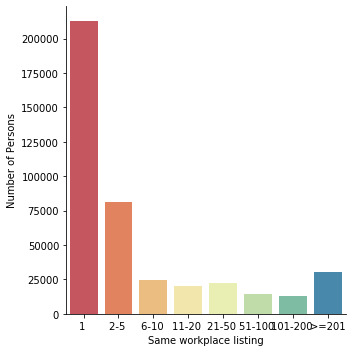

<Figure size 3200x6400 with 0 Axes>

In [31]:
companyCounts=tableUniqueFullNameCounts['count']

#establish the binvals
binVals=np.asarray([0,1,5,10,20,50,100,200,np.max(companyCounts)])

#iterate to sum the number of employees meeting the criterion
binSum=np.zeros([len(binVals)-1,1])
for iBins in range(len(binVals)-1):
    binSum[iBins]=sum(companyCounts[np.logical_and(companyCounts>binVals[iBins],companyCounts<=binVals[iBins+1])])

#import plotting package
import seaborn as sns
#set the name vector    
binNames=['1 ','2-5 ','6-10 ','11-20 ','21-50 ','51-100 ','101-200 ', '>=201']
#set the axes labels
workplaceSizeTable=pd.DataFrame(columns=["Same workplace listing","Number of Persons"])
workplaceSizeTable['Number of Persons']=np.squeeze(binSum)
workplaceSizeTable['Same workplace listing']=np.squeeze(binNames)

#plot the output
sns.catplot(data=workplaceSizeTable, kind="bar", x='Same workplace listing',y='Number of Persons', palette='Spectral');
plt.figure(figsize=(16,32),dpi=200)

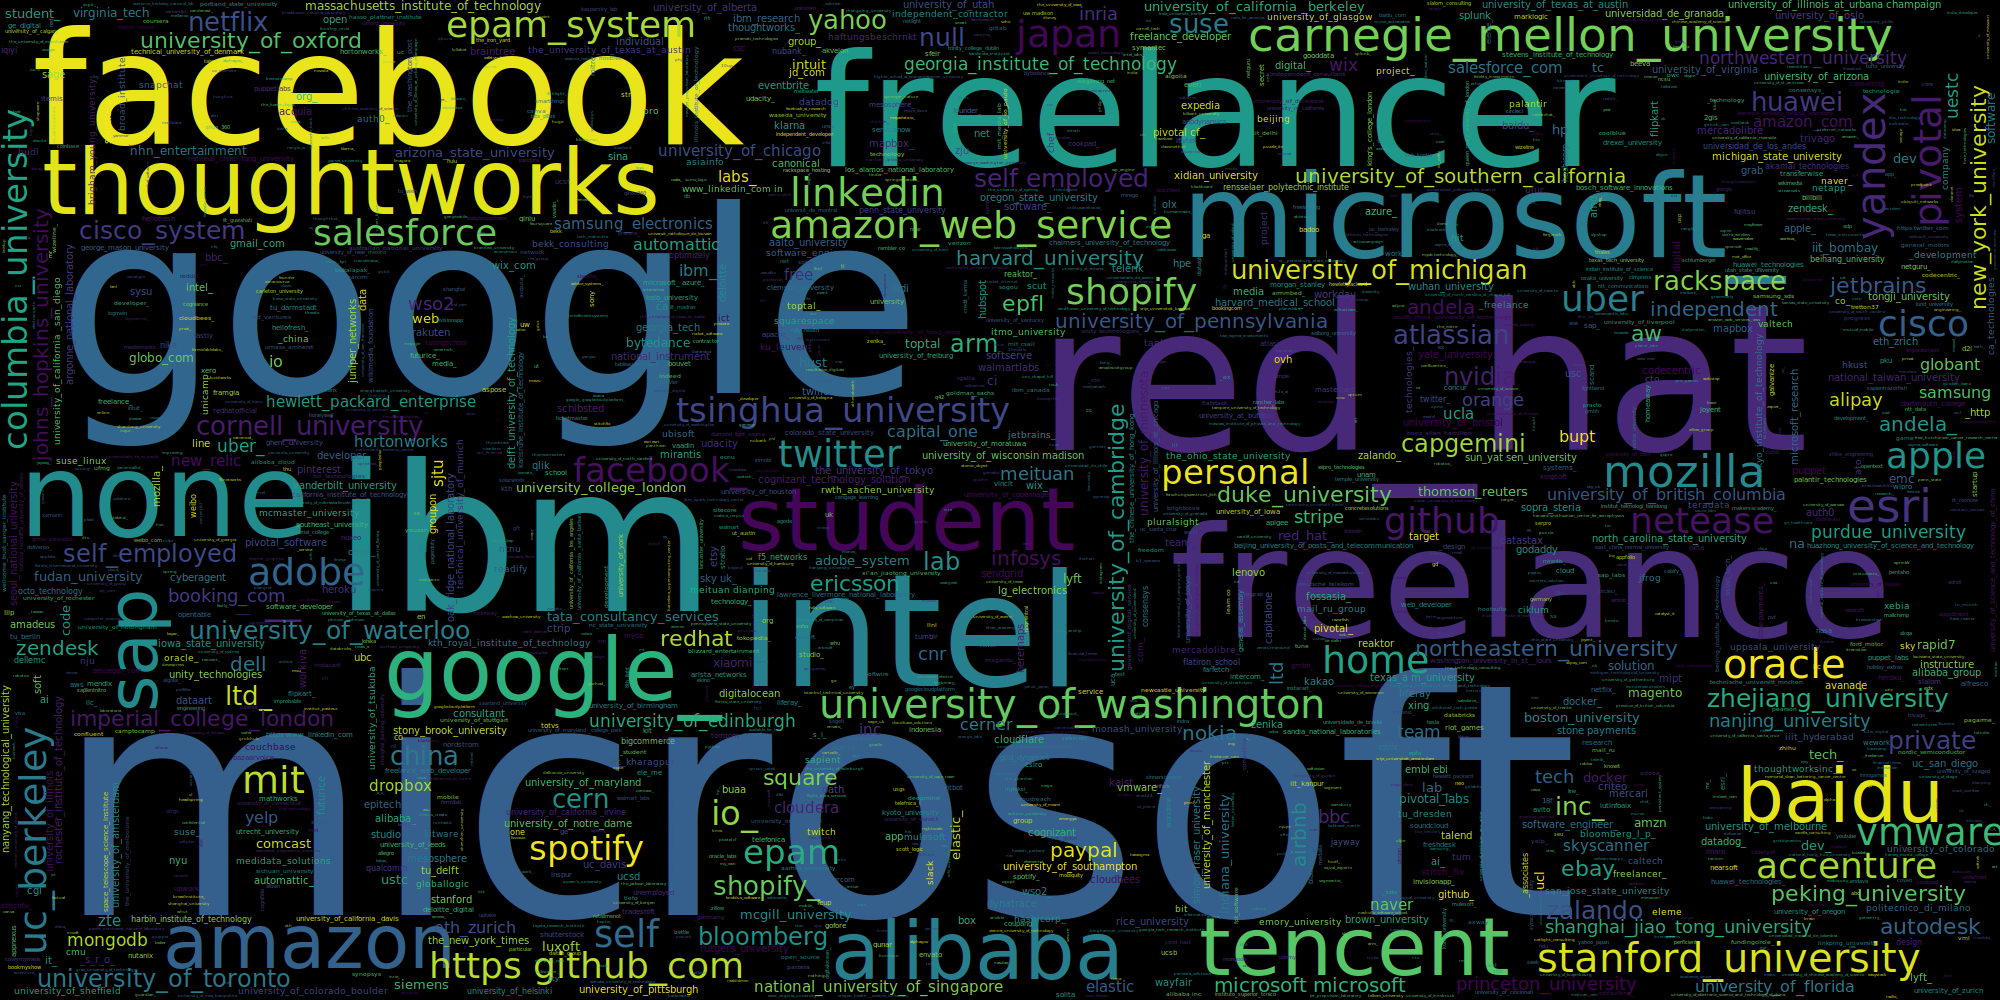

In [33]:
#replace interior spaces and periods (which the wordcloud splits at)
spacesReplaced=finalOut['company'].str.replace(' ','_')
periodsReplaced=spacesReplaced.str.replace('\.','_')

#turn that output into a long string
longString=periodsReplaced.str.cat(sep=' ')

#generate a wordcloud and convert it to svg
outcloud=wordcloud.WordCloud(width=2000, height=1000, max_words=2000).generate(longString)
svgCloud=outcloud.to_svg()
IPython.display.SVG(svgCloud)